In [2]:
import numpy as np
import torch
import librosa
from librosa import stft, istft
from sphfile import SPHFile
import os
from pathlib import Path
from random import choice, randint
from matplotlib import pyplot as plt

from models import build_model
from utils import get_mag_phase
from evaluate import compute_snr
import soundfile

In [3]:
BASE_DIR = Path(os.getcwd()).parent
DATA_DIR = BASE_DIR / 'data'
split = 'val'
k = 1024
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TEST_DIR = Path(os.getcwd()).parent / 'test'
os.makedirs(TEST_DIR, exist_ok=True)

In [4]:
noise_list = open(os.path.join(DATA_DIR, 'noise_list.txt')).readlines()
file_list = open(os.path.join(DATA_DIR, '%s_set.txt'%(split))).readlines()

In [5]:
len_signal = 0
alpha = 0.8 #choice((6,9))/10 # random alpha
snr = np.random.randint(-5, 1, (1,))
print(snr)

while len_signal/k <= 64:
    # Randomly sample clean speech
    xx = os.path.join(BASE_DIR, choice(file_list)).rstrip()
    sph_data = SPHFile(xx)
    samp_rate = sph_data.format['sample_rate']
    # Randomly sample noise
    noise_data = librosa.load(os.path.join(BASE_DIR, choice(noise_list)).rstrip(), sr=samp_rate)
    noise_signal = noise_data[0]

    # Mixing noise with clean speech
    clean_signal = sph_data.content / (2**(sph_data.format['sample_sig_bits'] - 1))

    len_signal = min(clean_signal.shape[0], noise_signal.shape[0])

print(xx)
# limit signal length to k*64
len_signal = k*64-1

start_n = randint(0, max(0, noise_signal.shape[0] - clean_signal.shape[0]))

# randomly sample a window from noise sequence to be mixed
noise_signal = noise_signal[start_n:start_n+len_signal]
clean_signal = clean_signal[0:len_signal]
# mixed_signal = alpha * clean_signal + (1-alpha) * noise_signal

p_noise = np.average(noise_signal**2)
p_signal = np.average(clean_signal**2)
alpha = np.sqrt(p_signal/p_noise * 10**-(snr/10))
print(alpha)

mixed_signal = clean_signal + alpha * noise_signal

stft_clean = stft(clean_signal, win_length=k, n_fft=k)
stft_mixed = stft(mixed_signal, win_length=k, n_fft=k)

[-1]
/home/sazim/teams/ece251c-team-11/data/clean_data/039256.sph
[1.27694856]


In [ ]:
sph_data.content

In [ ]:
np.max(clean_signal),np.min(clean_signal)

In [ ]:
np.max(noise_signal),np.min(noise_signal)

In [6]:
clean_spec = torch.tensor(stft_clean)
noisy_spec = torch.tensor(stft_mixed)

In [ ]:
# save nosiy speech as wav file
soundfile.write(os.path.join(TEST_DIR,'noisy_speech.wav'), mixed_signal, samp_rate)
soundfile.write(os.path.join(TEST_DIR,'gt_clean_speech.wav'), clean_signal, samp_rate)

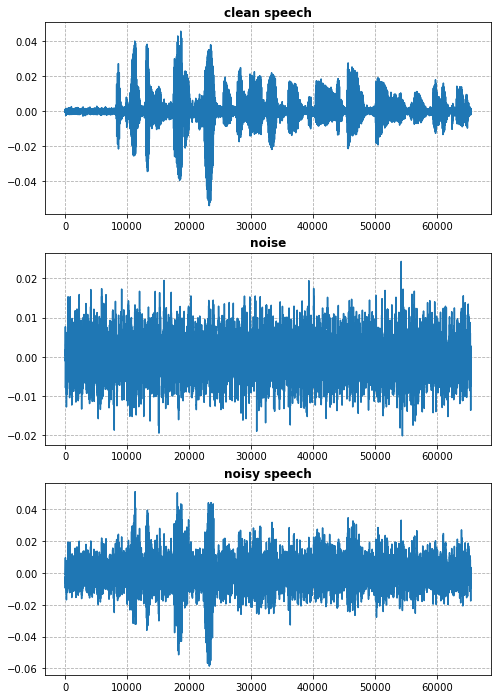

In [29]:
fig = plt.figure(figsize=(8,12))
# plt.plot(clean_signal)
# plt.subplot(clean_signal)
ax1 = plt.subplot(3,1,1)
plt.plot(clean_signal)
plt.grid(linestyle='--')
plt.title('clean speech', fontweight='bold')

# plt.plot(x,y)

ax2 = plt.subplot(3,1,2)
plt.plot(noise_signal)
plt.grid(linestyle='--')
plt.title('noise', fontweight='bold')

ax2 = plt.subplot(3,1,3)
plt.plot(mixed_signal)
plt.grid(linestyle='--')
plt.title('noisy speech', fontweight='bold')

# plt.subtitle("")
fig.savefig("../plots/time_domain_plots.png")

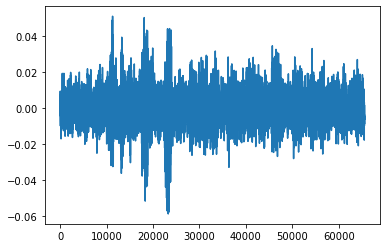

In [10]:
plt.plot(mixed_signal)

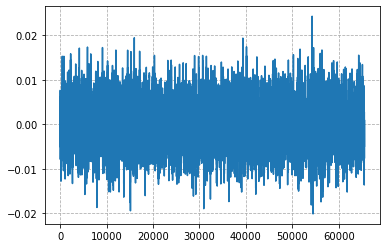

In [13]:
plt.plot(noise_signal)
plt.grid(linestyle='--')


In [2]:
# model specification
args = {}
args['model'] = {}
args['model']['type'] = 'mag_only' # mag_phase
args['model']['pooling'] = 'wavelet' # maxpool
args['model']['wavelet'] =  'bior1.1' # wavelet type
args['exp_name'] = 'm1_bior'

In [3]:
# build model
model, _ = build_model(args['model'])
# model = model.to(device)

Model to denoise only the magnitude spectrum....
wavelet pooling ...



In [12]:
from torchsummary import summary
summary(model, (1, 512, 256), (1, 512, 256))

RuntimeError: Failed to run torchsummary. See above stack traces for more details. Executed layers up to: [CausalConvBlock: 1-1, Conv2d: 2-1, Pooling: 2-2, WaveletPooling: 3-1, BatchNorm2d: 2-3, ReLU: 2-4, CausalConvBlock: 1-2, Conv2d: 2-5, Pooling: 2-6, WaveletPooling: 3-2, BatchNorm2d: 2-7, ReLU: 2-8, CausalConvBlock: 1-3, Conv2d: 2-9, Pooling: 2-10, WaveletPooling: 3-3, BatchNorm2d: 2-11, ReLU: 2-12, CausalConvBlock: 1-4, Conv2d: 2-13, Pooling: 2-14, WaveletPooling: 3-4, BatchNorm2d: 2-15, ReLU: 2-16, CausalConvBlock: 1-5, Conv2d: 2-17, Pooling: 2-18, WaveletPooling: 3-5, BatchNorm2d: 2-19, ReLU: 2-20]

In [ ]:
# Load weights from checkpoint
# exp_folder = '/home/sazim/teams/ece251c-team-11/experiments' # lower res spec
exp_folder = '/home/pakumar/teams/ece251c-team-11/experiments/' # higher res spec
ckpt = torch.load(os.path.join(exp_folder, args['exp_name'], 'checkpoint.pth'))
model.load_state_dict(ckpt['state_dict'])

In [ ]:
clean_spec = clean_spec.to(device)
noisy_spec = noisy_spec.to(device)
noisy_mag, noisy_phase = get_mag_phase(noisy_spec)

In [ ]:
# forward pass
model.eval()
pred_mag, pred_phase = model(noisy_mag, noisy_phase)

In [ ]:
pred_mag = pred_mag.cpu().detach().numpy().squeeze()
pred_phase = pred_phase.cpu().detach().numpy().squeeze()

In [ ]:
pred_spec = pred_mag + pred_phase*1j

In [ ]:
# save 
pred_clean_signal = istft(pred_spec, win_length=k, n_fft=k)

# save nosiy speech as wav file
soundfile.write(os.path.join(TEST_DIR,'clean_speech.wav'), pred_clean_signal, samp_rate)